In [5]:
import numpy as np
import pandas as pd

np.random.seed(23) 

# Class 1
mu_vec1 = np.array([0, 0, 0])
cov_mat1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20)

df = pd.DataFrame(class1_sample, columns=['feature1', 'feature2', 'feature3'])
df['target'] = 1

# Class 2
mu_vec2 = np.array([1, 1, 1])
cov_mat2 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20)

df1 = pd.DataFrame(class2_sample, columns=['feature1', 'feature2', 'feature3'])
df1['target'] = 0

# ✅ Correct concatenation
df = pd.concat([df, df1], ignore_index=True)

# ✅ Correct shuffling
df = df.sample(40).reset_index(drop=True)

print(df.head())


   feature1  feature2  feature3  target
0 -0.367548 -1.137460 -1.322148       1
1  0.177061 -0.598109  1.226512       0
2  0.420623  0.411620 -0.071324       1
3  1.968435 -0.547788 -0.679418       1
4 -2.506230  0.146960  0.606195       1


In [8]:
!pip install plotly

import plotly.express as px
#y_train_trf = y_train.astype(str)
fig = px.scatter_3d(df, x=df['feature1'], y=df['feature2'], z=df['feature3'],
              color=df['target'].astype('str'))
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

In [12]:
import plotly.express as px
import plotly.io as pio

# Force browser rendering (works everywhere)
pio.renderers.default = "browser"

fig = px.scatter_3d(
    df,
    x='feature1',
    y='feature2',
    z='feature3',
    color=df['target'].astype(str),
    title='3D Scatter Plot of Two Classes'
)

fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))
fig.show()



In [13]:
# Step 1 - Apply standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df.iloc[:,0:3] = scaler.fit_transform(df.iloc[:,0:3])
     

# Step 2 - Find Covariance Matrix
covariance_matrix = np.cov([df.iloc[:,0],df.iloc[:,1],df.iloc[:,2]])
print('Covariance Matrix:\n', covariance_matrix)

Covariance Matrix:
 [[1.02564103 0.20478114 0.080118  ]
 [0.20478114 1.02564103 0.19838882]
 [0.080118   0.19838882 1.02564103]]


In [15]:

# Step 3 - Finding EV and EVs
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
     

eigen_values

array([1.3536065 , 0.94557084, 0.77774573])

In [16]:
eigen_vectors

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442],
       [-0.52848211,  0.72025103,  0.44938304]])

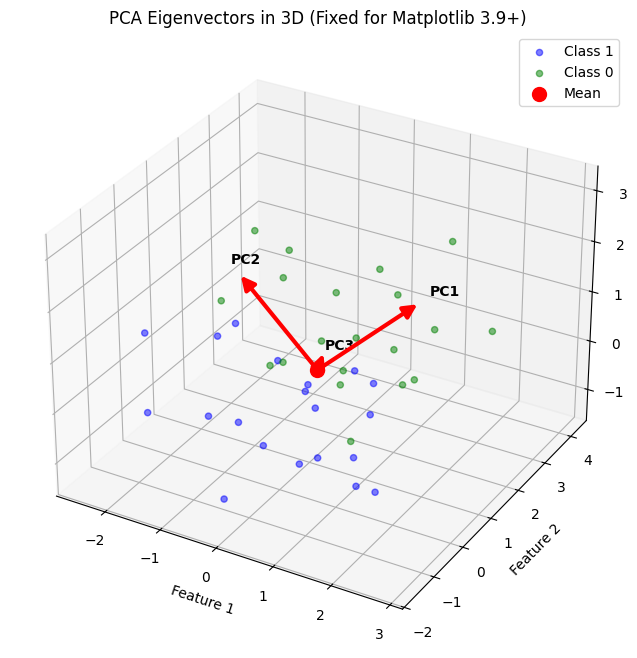

In [20]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
from matplotlib.patches import FancyArrowPatch

# -----------------------------
# 1️⃣ Generate synthetic data
# -----------------------------
np.random.seed(23)
mu_vec1 = np.array([0, 0, 0])
mu_vec2 = np.array([1, 1, 1])
cov = np.eye(3)

class1 = np.random.multivariate_normal(mu_vec1, cov, 20)
class2 = np.random.multivariate_normal(mu_vec2, cov, 20)

df = pd.DataFrame(np.vstack((class1, class2)), columns=['feature1', 'feature2', 'feature3'])
df['target'] = [1]*20 + [0]*20

# -----------------------------
# 2️⃣ Perform PCA
# -----------------------------
X = df[['feature1', 'feature2', 'feature3']]
pca = PCA(n_components=3)
pca.fit(X)

eigen_vectors = pca.components_.T
mean_vec = X.mean().values

# -----------------------------
# 3️⃣ Updated Arrow3D (for Matplotlib ≥3.9)
# -----------------------------
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        # ✅ Use self.axes.M instead of renderer.M
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.get_proj())
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.get_proj())
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

# -----------------------------
# 4️⃣ Plotting
# -----------------------------
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the classes
ax.scatter(df.loc[df['target'] == 1, 'feature1'],
           df.loc[df['target'] == 1, 'feature2'],
           df.loc[df['target'] == 1, 'feature3'],
           color='blue', alpha=0.5, label='Class 1')

ax.scatter(df.loc[df['target'] == 0, 'feature1'],
           df.loc[df['target'] == 0, 'feature2'],
           df.loc[df['target'] == 0, 'feature3'],
           color='green', alpha=0.5, label='Class 0')

# Mean of data
ax.scatter(mean_vec[0], mean_vec[1], mean_vec[2],
           color='red', s=100, label='Mean')

# Plot eigenvectors (principal components)
for i in range(3):
    vec = eigen_vectors[:, i]
    arrow = Arrow3D([mean_vec[0], mean_vec[0] + 2*vec[0]],
                    [mean_vec[1], mean_vec[1] + 2*vec[1]],
                    [mean_vec[2], mean_vec[2] + 2*vec[2]],
                    mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(arrow)
    # Label the vector
    ax.text(mean_vec[0] + 2.2*vec[0],
            mean_vec[1] + 2.2*vec[1],
            mean_vec[2] + 2.2*vec[2],
            f"PC{i+1}", color="black", fontsize=10, weight='bold')

# Label axes
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.title('PCA Eigenvectors in 3D (Fixed for Matplotlib 3.9+)')
ax.legend()
plt.show()


In [21]:
pc = eigen_vectors[0:2]
pc
    

array([[ 0.61002583, -0.69239396, -0.3853039 ],
       [ 0.53982115,  0.00718615,  0.84174906]])

In [22]:
transformed_df = np.dot(df.iloc[:,0:3],pc.T)
# 40,3 - 3,2
new_df = pd.DataFrame(transformed_df,columns=['PC1','PC2'])
new_df['target'] = df['target'].values
new_df.head()

,PC1,PC2,target
0,0.688627,-0.294321,1
1,0.497844,-0.367612,1
2,1.072785,-1.319501,1
3,1.063494,1.518295,1
4,0.556858,-0.703920,1


In [23]:

new_df['target'] = new_df['target'].astype('str')
fig = px.scatter(x=new_df['PC1'],
                 y=new_df['PC2'],
                 color=new_df['target'],
                 color_discrete_sequence=px.colors.qualitative.G10
                )

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()
     